In [538]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

import plotly as ply
import plotly.graph_objects as go

sns.set() 

plt.rcParams['font.family']= 'Malgun Gothic'  # 한글 처리
plt.rcParams['axes.unicode_minus'] = False  # -, $ 등등에 표현 특수기호로 버리지 말고 다 써줘라.

주요 Event:
* 코로나: 2019년도 12월부터 시작

# read data, preprocessing

In [539]:
df1 = pd.read_csv('./data/블록별 성별연령대별 카드소비패턴.csv', encoding='cp949')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   서울시민업종코드(UPJONG_CD)  500 non-null    object
 1   기준년월(YM)             500 non-null    int64 
 2   고객주소블록코드(BLOCK_CD)   500 non-null    int64 
 3   성별(GEDNER)           500 non-null    object
 4   연령대별(AGE)            500 non-null    object
 5   카드이용금액계(AMT_CORR)    500 non-null    int64 
 6   카드이용건수계(USECT_CORR)  500 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 27.5+ KB


In [540]:
df2 = pd.read_csv('./data/카드소비 업종코드.csv', encoding='cp949')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   업종코드(UPJONG_CD)  75 non-null     object
 1   대분류(CLASS1)      75 non-null     object
 2   중분류(CLASS2)      75 non-null     object
 3   소분류(CLASS3)      75 non-null     object
dtypes: object(4)
memory usage: 2.5+ KB


In [541]:
df1['년'] = df1['기준년월(YM)'].astype('str').str[:4]
df1['월'] = df1['기준년월(YM)'].astype('str').str[4:]

In [542]:
df1.rename(columns = {'서울시민업종코드(UPJONG_CD)' : '업종코드', '성별(GEDNER)' : '성별', '카드이용금액계(AMT_CORR)' : '금액', '카드이용건수계(USECT_CORR)' : '건수', '연령대별(AGE)' : '연령'}, inplace = True)
df2.rename(columns = {'업종코드(UPJONG_CD)' : '업종코드', '대분류(CLASS1)' : '대분류', '중분류(CLASS2)' : '중분류', '소분류(CLASS3)' : '소분류'}, inplace = True)
df2['업종코드'] = df2['업종코드'].str.upper()
mgdf = pd.merge(df1, df2, on='업종코드', how='left')

mgdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   업종코드                500 non-null    object
 1   기준년월(YM)            500 non-null    int64 
 2   고객주소블록코드(BLOCK_CD)  500 non-null    int64 
 3   성별                  500 non-null    object
 4   연령                  500 non-null    object
 5   금액                  500 non-null    int64 
 6   건수                  500 non-null    int64 
 7   년                   500 non-null    object
 8   월                   500 non-null    object
 9   대분류                 500 non-null    object
 10  중분류                 500 non-null    object
 11  소분류                 500 non-null    object
dtypes: int64(4), object(8)
memory usage: 50.8+ KB


In [543]:
df = mgdf[['대분류','중분류','소분류', '성별', '연령', '년', '월', '금액', '건수']]
df.head()

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
0,유통,할인점/슈퍼마켓,할인점/슈퍼마켓,F,50대,2019,06,48288,65
1,가정생활/서비스,각종요금,통신,M,30대,2016,08,132792,10
2,유통,편의점,편의점,M,50대,2020,09,100600,25
3,요식/유흥,한식,한식,F,30대,2018,05,213876,40
4,가정생활/서비스,서비스,생활서비스,M,30대,2017,05,155930,5


In [544]:
df['대분류'] = df['대분류'].replace(['가전/가구','가정생활/서비스'],'가정생활')
df['대분류'] = df['대분류'].replace('교육/학원','교육')
df['대분류'] = df['대분류'].replace(['스포츠/문화/레저','여행/교통'],'문화')
df['대분류'] = df['대분류'].replace(['주유','자동차'],'교통')
df['대분류'] = df['대분류'].replace(['요식/유흥','음/식료품'],'식품')
df['대분류'] = df['대분류'].replace(['의류/잡화','미용'],'패션')
df['대분류'].value_counts()

식품       142
유통        89
가정생활      55
의료        55
문화        47
전자상거래     45
패션        36
교통        19
교육        12
Name: 대분류, dtype: int64

## 이상치 처리

In [545]:
df[(df['연령']=='10대')&(df['대분류']=='교통')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
428,교통,주유,LPG,F,10대,2020,06,8722976,50


In [546]:
df[(df['성별']=='F')&(df['대분류']=='교통')&(df['연령']=='60대')&(df['년']=='2018')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
216,교통,자동차서비스/용품,자동차용품,F,60대,2018,10,14336,795


In [547]:
df[(df['대분류']=='식품')&(df['연령']=='10대')&(df['성별']=='F')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
232,식품,일식/중식/양식,중식,F,10대,2017,08,11102382,25


In [548]:
df[(df['대분류']=='식품')&(df['연령']=='10대')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
11,식품,기타요식,기타요식,M,10대,2018,04,6698074,30
232,식품,일식/중식/양식,중식,F,10대,2017,08,11102382,25


In [549]:
df[(df['대분류']=='식품')&(df['연령']=='10대')&(df['성별']=='F')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
232,식품,일식/중식/양식,중식,F,10대,2017,08,11102382,25


In [550]:
df[(df['년']=='2021')&(df['대분류']=='전자상거래')&(df['성별']=='M')&(df['연령']=='20대')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
30,전자상거래,전자상거래,결제대행(PG),M,20대,2021,03,50385007,5


In [551]:
# drop
df = df.drop(df[(df['연령']=='10대')&(df['대분류']=='교통')].index.values[0], axis=0)

In [552]:
idxv = df[(df['성별']=='F')&(df['대분류']=='교통')&(df['연령']=='60대')&(df['년']=='2018')].index.values[0]
df = df.drop(idxv, axis=0)

In [553]:
idxv = df[(df['대분류']=='식품')&(df['연령']=='10대')&(df['성별']=='F')].index.values[0]
df = df.drop(idxv, axis=0)

In [554]:
temp = df[(df['년']=='2021')&(df['대분류']=='전자상거래')&(df['성별']=='M')&(df['연령']=='20대')]
idxv =df[(df['년']=='2021')&(df['대분류']=='전자상거래')&(df['성별']=='M')&(df['연령']=='20대')].index.values[0]
df = df.drop(idxv, axis=0)
temp['금액'] = int(temp['금액'].values[0]/4)
df = pd.concat([df, temp], axis=0)
df[(df['년']=='2021')&(df['대분류']=='전자상거래')&(df['성별']=='M')&(df['연령']=='20대')]

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
30,전자상거래,전자상거래,결제대행(PG),M,20대,2021,03,12596251,5


In [555]:
temp_df = df[(df['대분류']=='식품')&(df['연령']=='20대')&((df['소분류']=='한식')|(df['소분류']=='기타음/식료품'))].sort_values('년')
temp_df = temp_df[((temp_df['년']!='2018')|(temp_df['월']!='04'))]
temp_df = temp_df[((temp_df['년']!='2018')|(temp_df['월']!='07'))]
temp_df['연령']= '10대'
temp_df

,대분류,중분류,소분류,성별,연령,년,월,금액,건수
248,식품,한식,한식,M,10대,2016,12,2087953,45
212,식품,한식,한식,F,10대,2017,09,161966,15
376,식품,한식,한식,M,10대,2017,10,27162,5
179,식품,음/식료품,기타음/식료품,M,10대,2019,12,72935,70
436,식품,한식,한식,F,10대,2019,11,35713,91
240,식품,한식,한식,M,10대,2020,12,464772,5
263,식품,한식,한식,F,10대,2020,04,118708,15
420,식품,음/식료품,기타음/식료품,F,10대,2021,05,20623,5


In [556]:
df = pd.concat([df, temp_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 420
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   대분류     505 non-null    object
 1   중분류     505 non-null    object
 2   소분류     505 non-null    object
 3   성별      505 non-null    object
 4   연령      505 non-null    object
 5   년       505 non-null    object
 6   월       505 non-null    object
 7   금액      505 non-null    int64 
 8   건수      505 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 39.5+ KB


In [557]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 420
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   대분류     505 non-null    object
 1   중분류     505 non-null    object
 2   소분류     505 non-null    object
 3   성별      505 non-null    object
 4   연령      505 non-null    object
 5   년       505 non-null    object
 6   월       505 non-null    object
 7   금액      505 non-null    int64 
 8   건수      505 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 39.5+ KB


# 성별

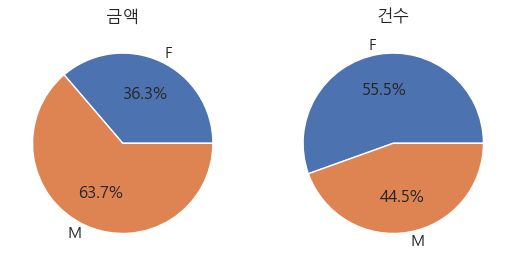

In [558]:
# 분석 결과, 2016-2023년도 까지 금액의 성별에 따른 금액의 총합과 건수의 평균으로 표시
# 건수의 경우, 여성이 높으나 금액은 남성이 높음.
meandata = df.groupby('성별')['금액'].mean()
ratio1 = meandata.values
labels1 = meandata.index.values

meandata2 = df.groupby('성별')['건수'].mean()
ratio2 = meandata2.values
labels2 = meandata2.index.values

plt.subplot(1,2,1)
plt.title('금액')
plt.pie(ratio1, labels=labels1, autopct='%.1f%%')

plt.subplot(1,2,2)
plt.title('건수')
plt.pie(ratio2, labels=labels2, autopct='%.1f%%')

plt.show()

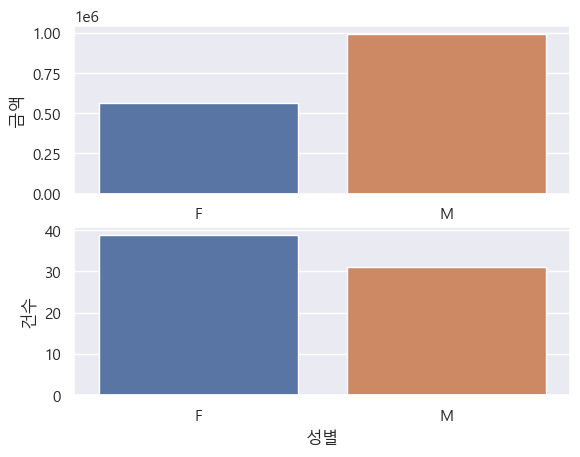

In [559]:
gdf = df.groupby('성별')[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.subplot(2,1,1)
sns.barplot(data=gdf, x="성별", y="금액") 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x="성별", y="건수") 
plt.show()

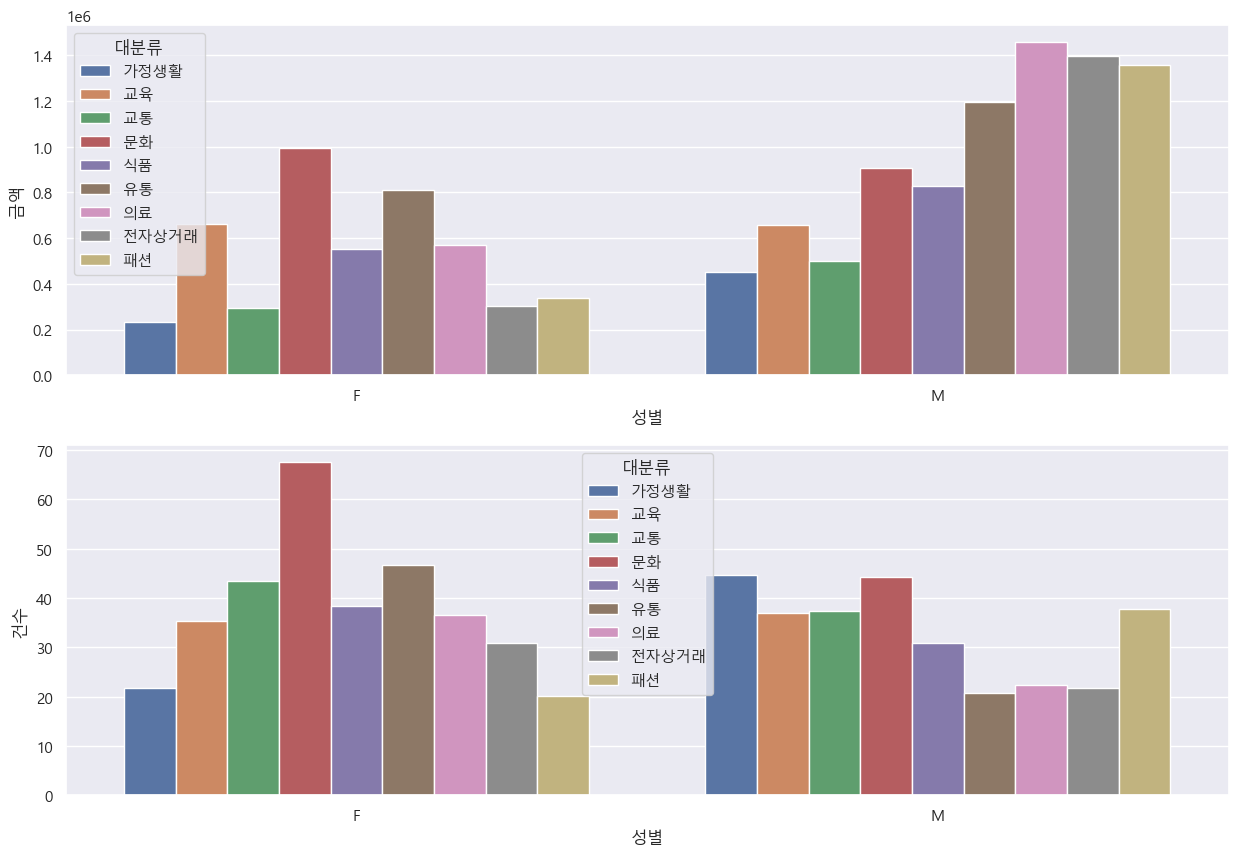

In [560]:
# 성별에 따른 금액과 건수를 대분류로 나눈 결과
# 남성의 경우 전자상거래에서 소비 금액이 아주 큼.
# 여성의 경우 교통에서 결제 건수가 많은 것으로 나타남. ??  --> 해당 이유 파악 필요.
gdf = df.groupby(['성별', '대분류'])[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.barplot(data=gdf, x="성별", y="금액", hue='대분류') 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x="성별", y="건수", hue='대분류') 
plt.show()

# 연령별

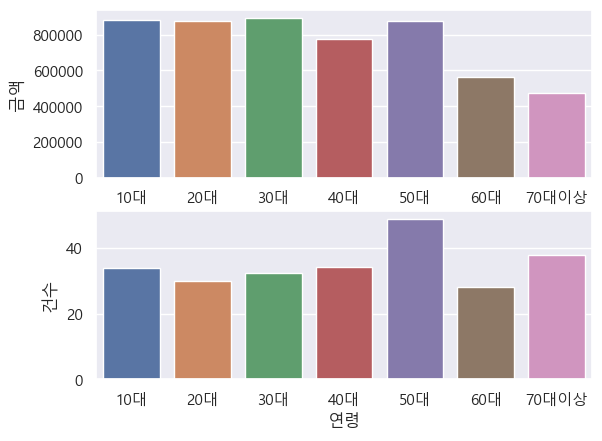

In [561]:
# 연령별, 금액, 건수
# 10대의 소비 금액이 높음.
# 건수의 경우 50개의 소비 건수가 가장 높으나, 금액은 높지 않음.
# 즉, 50개 소비 패턴이 상대적으로, 금액이 적은 소비를 자주 하는 것으로 보임.

gdf = df.groupby('연령')[['금액', '건수']].mean().sort_index()

plt.subplot(2,1,1)
sns.barplot(data=gdf, x=gdf.index, y="금액") 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x=gdf.index, y="건수") 
plt.show()

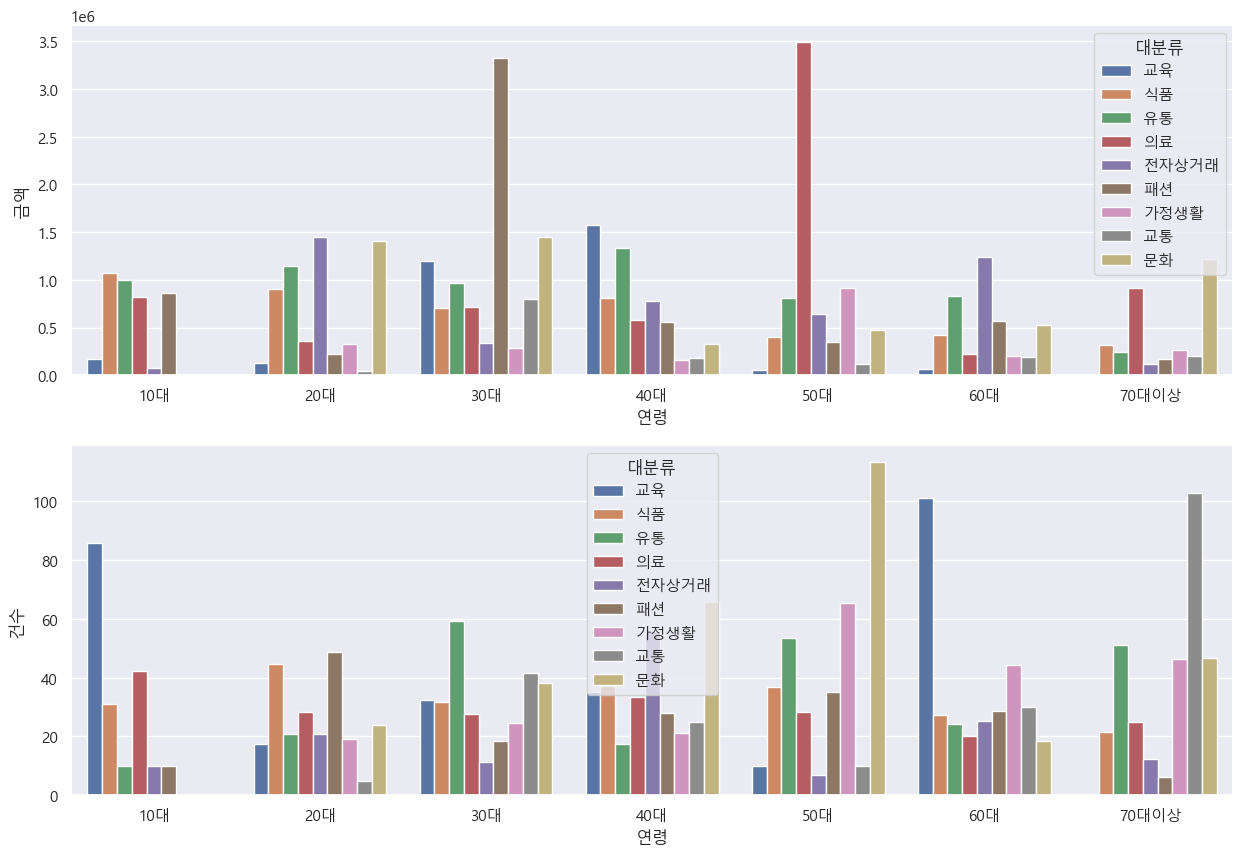

In [562]:
gdf = df.groupby(['연령', '대분류'])[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.barplot(data=gdf, x='연령', y="금액", hue='대분류') 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x='연령', y="건수", hue='대분류') 
plt.show()

# 10대의 교통과 식품 소비 금액이 매우 높음. 교통(자동차, 주유)이 높게 나오는 근거가 부족. 
# 20대의 전자상거래, 소비금액이 높고, 50대의 의료 비용이 높음.
# 60~70대의 경우, 교통 소비 금액은 높지 않으나, 건수는 높게 나옴. 교통에 적은 금액을 자주 사용하는 것으로 보임.

# 연도별

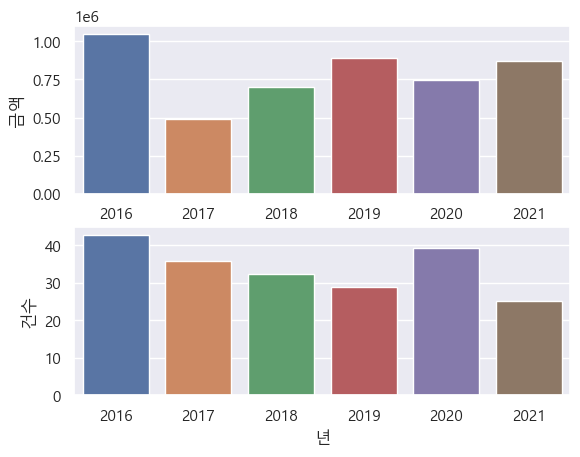

In [563]:
# 연도별 금액, 건수
# 2021년도, 건수는 높지 않으나, 금액이 높게 나옴.  (2021년도에 금액이 큰 소비가 발생함.)
# 2016년도에 금액과 건수 모두 높았다.
# 2021년도의 겨우 건수는 적으나, 금액이 높음. 2021년도에 사람들이 금액이 큰 소비를 한듯함.
gdf = df.groupby('년')[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.subplot(2,1,1)
sns.barplot(data=gdf, x='년', y="금액") 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x='년', y="건수") 
plt.show()

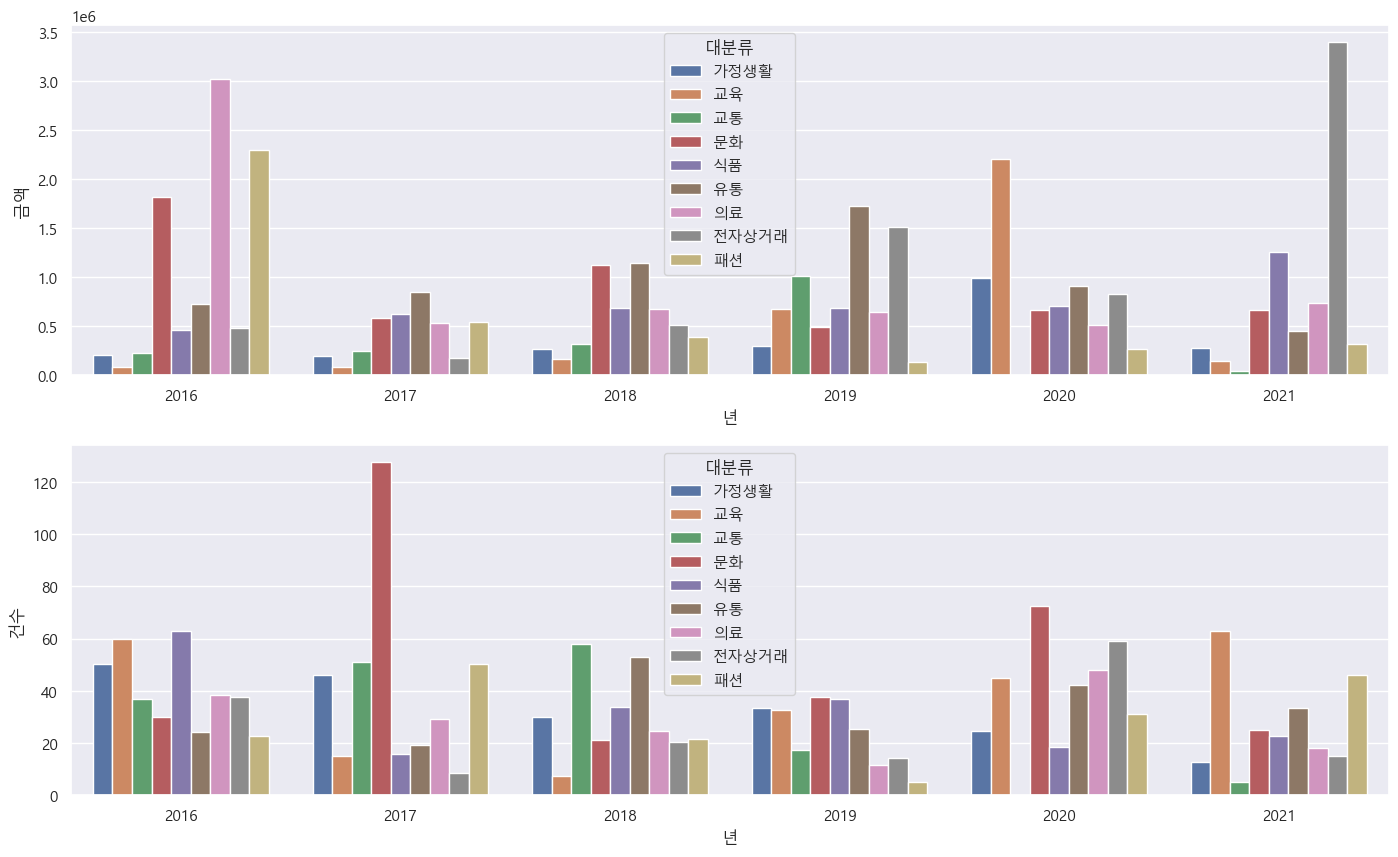

In [564]:
# 연도에 따른 성별별 금액, 건수 비교 차트 
gdf = df.groupby(['년', '대분류'])[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.figure(figsize=(17,10))
plt.subplot(2,1,1)
sns.barplot(data=gdf, x='년', y="금액", hue='대분류') 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x='년', y="건수", hue='대분류') 
plt.show()

# 월별

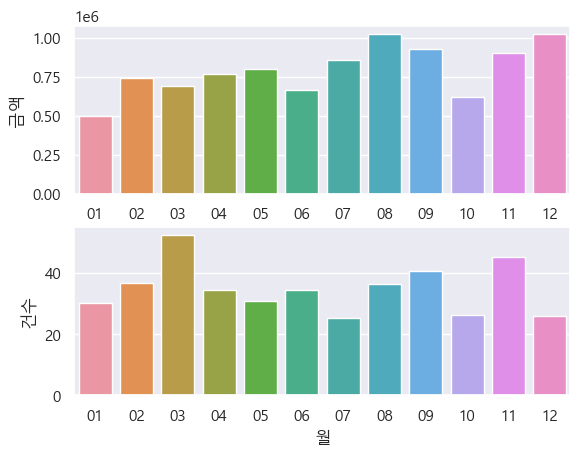

In [565]:
gdf = df.groupby('월')[['금액', '건수']].mean().sort_index()
gdf = gdf.reset_index()

plt.subplot(2,1,1)
sns.barplot(data=gdf, x='월', y="금액") 
plt.subplot(2,1,2)
sns.barplot(data=gdf, x='월', y="건수") 
plt.show()